In [24]:
from IPython.display import Image

import sys
sys.path.append("/home/xilinx/fos/udmalib")
sys.path.append("/home/xilinx/fos/")

import udma as udma
from ponq import ponq
import cv2, numpy as np



DRIVER: Loading bitfile Ultra96_100MHz_2.bin onto /sys/class/fpga_manager/fpga0
DRIVER: Instanciating Shell Ultra96_100MHz_2
DRIVER: Loading Partial_mandelbrot into region pr0
DRIVER: Loading bitfile Blanking_slot_0.bin onto /sys/class/fpga_manager/fpga0
DRIVER: Loading bitfile Partial_mandelbrot_slot_0.bin onto /sys/class/fpga_manager/fpga0


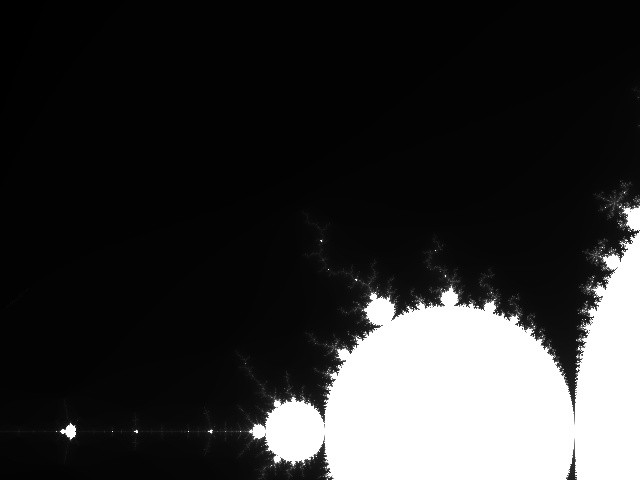

In [28]:
# bit hacking functions for driving unit
fixpfactor = 1 << 29
int32max = (1 << 32) - 1
def float2fix(value): return int(value * fixpfactor)
def top32(data): return int((data >> 32) & int32max)
def bot32(data): return int(data & int32max)

# load udma buffer for hardware use
udmarepo = udma.udmas()
udmadev = udmarepo.getDevice(0)
ubuf = udmadev.map()

# hardware module parameters
udma_addy = udmadev.phys_addr
width = 640
height = 480
cre = -1.2582
cim = 0.3819
zoom = 0.002

# initialise ponq & shell to host
manager = ponq.Ponq(repository="/home/xilinx/fos/bitstreams")
manager.loadShell("Ultra96_100MHz_2")

# run unit
manager.run("Partial_mandelbrot", {
    "imageWidth":     width,
    "imageHeight":    height,
    "maxIterations":  256,
    "centreRealLow":  bot32(float2fix(cre)),
    "centreRealHi":   top32(float2fix(cre)),
    "centreImagLow":  bot32(float2fix(cim)),
    "centreImagHi":   top32(float2fix(cim)),
    "zoomLow":        bot32(float2fix(zoom)),
    "zoomHi":         top32(float2fix(zoom)),
    "framebufferLow": bot32(udma_addy),
    "framebufferHi":  top32(udma_addy)
})

# write bitmap data to file
output = np.zeros((height, width), dtype=np.uint8)
for y in range(height):
    for x in range(width):
        output[y, x] = ubuf[y*width+x]
cv2.imwrite("mandelbrot.jpg", output)

# display file
Image("mandelbrot.jpg")